In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Load in Vehicle and non Vehicle images
===


In [26]:

import glob
import os

%matplotlib qt
import numpy as np

vehicle_images = 'vehicles/'
images = os.listdir(vehicle_images)

vehicles = []

for image in images:
    vehicles.extend(glob.glob(vehicle_images+image+'/G*/*'))
    vehicles.extend(glob.glob(vehicle_images+image+'/K*/*'))

print("No of vehicles images: ", len(vehicles))

non_vehicle_images = 'non-vehicles/'
images = os.listdir(non_vehicle_images)

non_vehicles = []

for image in images:
    non_vehicles.extend(glob.glob(non_vehicle_images+image+'/GTI*/*'))
    non_vehicles.extend(glob.glob(non_vehicle_images+image+'/E*/*'))

print("No of vehicles images: ", len(non_vehicles))


No of vehicles images:  8792
No of vehicles images:  8968


### Visualize a random Vehicle and non Vehicle image

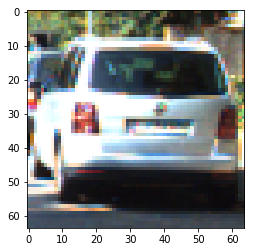

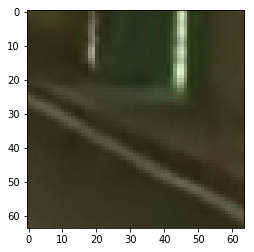

In [36]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

rnd = np.random.randint(0, len(vehicles))
img = mpimg.imread(vehicles[rnd])
plt.imshow(img)
plt.show()

rnd = np.random.randint(0, len(non_vehicles))
img = mpimg.imread(non_vehicles[rnd])
plt.imshow(img)
plt.show()

## Define relevant functions

### Define HOG features

In [41]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):
    
    if vis:
        hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=feature_vec, block_norm="L2-Hys")
        return hog_features, hog_image
    
    else:       
        hog_features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")                
        return hog_features

    

### Test HOG features function

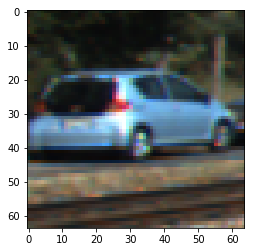

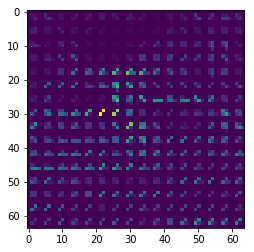

In [54]:
import cv2
# Select a random vehicle image

rnd = np.random.randint(0, len(vehicles))
img = mpimg.imread(vehicles[rnd])
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hog_features, hog_img = get_hog_features(gray, orient= 20, 
                        pix_per_cell= 4, cell_per_block= 2, 
                        vis=True, feature_vec=False)
plt.imshow(hog_img)
plt.show()


### Define spatial bins and color histograms

In [65]:
# Define a function to compute color histogram features

def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)

    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

### Test on random image

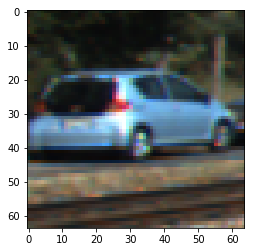

[314 378 291 220 313 264 273 207 221 240 219 146 157 165 145 113 102  84
  69  45  44  22  11   5   6   6   5   2   3  11   4  11 289 328 281 313
 302 361 307 185 143 132 127 145 143 159 133 152 127  83  63  53  66  59
  33  19  12  14  13   8   6  13   7  20 174 486 390 376 339 234 224 178
 138 163 150 205 169  99  68  33  40  51  59  43  52  50  38  27  37  41
  42  31  38  30  27  64]
96
[ 0.14215687  0.13921569  0.09705883 ...,  0.67745101  0.57745099
  0.46176472]
3072


In [67]:

hist_features = color_hist(img)
plt.imshow(img)
plt.show()
print(hist_features)
print(len(hist_features))

spatial_features = bin_spatial(img, color_space = 'RGB')
print(spatial_features)
print(len(spatial_features))

### Apply HLS color threshold

In [9]:
def hls_threshold(img, cspace, thresh=(90, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    if cspace == 'H':
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
        return binary
    elif cspace == 'L':
        binary = np.zeros_like(L)
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        return binary
    elif cspace == 'S':
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        return binary
    else:
        binary = np.zeros_like(H)
        return binary

### Apply RGB color threshold

In [10]:
def rgb_threshold(img, cspace, thresh=(90, 255)):
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    if cspace == 'R':
        binary = np.zeros_like(R)
        binary[(R > thresh[0]) & (R <= thresh[1])] = 1
        return binary
    elif cspace == 'G':
        binary = np.zeros_like(G)
        binary[(G > thresh[0]) & (G <= thresh[1])] = 1
        return binary
    elif cspace == 'B':
        binary = np.zeros_like(B)
        binary[(B > thresh[0]) & (B <= thresh[1])] = 1
        return binary
    else:
        binary = np.zeros_like(R)
        return binary

### Visualize a test image with direction and magnitude thresholds

In [11]:
'''

output_images_path = 'output_images/'
test_images = os.listdir(output_images_path)
save_images = 'saved_images_path/'

for image in test_images: 
    
    # load image
    img = cv2.imread(output_images_path+image)
    plt.gca().set_title('Original '+image)
    plt.imshow(img)
    plt.show()

    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find gradient in X direction
    abs = abs_sobel_thresh(gray, 'x', sobel_kernel = 3, thresh = (10, 100))
    abs*=255
    cv2.imwrite(save_images+'Sobel X '+image, abs)
    plt.gca().set_title('Sobel X '+image)
    plt.imshow(abs)
    plt.show()
    
    # find gradient in Y direction
    abs = abs_sobel_thresh(gray, 'y', sobel_kernel = 3, thresh = (10, 100))
    abs*=255
    cv2.imwrite(save_images+'Sobel Y'+image, abs)
    plt.gca().set_title('Sobel Y '+image)
    plt.imshow(abs)
    plt.show()
    
    
    # find the magnitude of the gradient
    mag = mag_thresh(gray, sobel_kernel = 3, mag_thresh = (10, 100))
    mag*=255
    cv2.imwrite(save_images+'Magnitude '+image, mag)
    plt.gca().set_title('Magnitude '+image)
    plt.imshow(mag)
    plt.show()

    # find the direction of the gradient and apply threshold
    dir = dir_threshold(gray, sobel_kernel=3, thresh=(np.pi/2.5, np.pi/2))
    dir*=255
    cv2.imwrite(save_images+'Direction '+image, dir)
    plt.gca().set_title('Direction '+image)
    plt.imshow(dir)
    plt.show()

    # find the color gradient and apply threshold
    h = hls_threshold(img, 'H', thresh=(90, 255))
    h*=255
    cv2.imwrite(save_images+'H Gradient '+image, h)
    plt.gca().set_title('H Gradient '+image)
    plt.imshow(h)
    plt.show()
    
    # find the color gradient and apply threshold
    l = hls_threshold(img, 'L', thresh=(90, 255))
    l*=255
    cv2.imwrite(save_images+'L Gradient '+image, l)
    plt.gca().set_title('L Gradient '+image)
    plt.imshow(l)
    plt.show()
    
    # find the color gradient and apply threshold
    s = hls_threshold(img, 'S', thresh=(100, 255))
    s*=255
    cv2.imwrite(save_images+'S Gradient '+image, s)
    plt.gca().set_title('S Gradient '+image)
    plt.imshow(s)
    plt.show()
    
    # find the color gradient and apply threshold
    r = rgb_threshold(img, 'R', thresh=(90, 255))
    r*=255
    cv2.imwrite(save_images+'R Gradient '+image, r)
    plt.gca().set_title('R Gradient '+image)
    plt.imshow(r)
    plt.show()
    
    # find the color gradient and apply threshold
    g = rgb_threshold(img, 'G', thresh=(90, 255))
    g*=255
    cv2.imwrite(save_images+'G Gradient '+image, g)
    plt.gca().set_title('G Gradient '+image)
    plt.imshow(g)
    plt.show()
    
    # find the color gradient and apply threshold
    b = rgb_threshold(img, 'B', thresh=(100, 255))
    b*=255
    cv2.imwrite(save_images+'B Gradient '+image, b)
    plt.gca().set_title('B Gradient '+image)
    plt.imshow(b)
    plt.show()
    
'''

"\n\noutput_images_path = 'output_images/'\ntest_images = os.listdir(output_images_path)\nsave_images = 'saved_images_path/'\n\nfor image in test_images: \n    \n    # load image\n    img = cv2.imread(output_images_path+image)\n    plt.gca().set_title('Original '+image)\n    plt.imshow(img)\n    plt.show()\n\n    # convert to grayscale\n    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n\n    # find gradient in X direction\n    abs = abs_sobel_thresh(gray, 'x', sobel_kernel = 3, thresh = (10, 100))\n    abs*=255\n    cv2.imwrite(save_images+'Sobel X '+image, abs)\n    plt.gca().set_title('Sobel X '+image)\n    plt.imshow(abs)\n    plt.show()\n    \n    # find gradient in Y direction\n    abs = abs_sobel_thresh(gray, 'y', sobel_kernel = 3, thresh = (10, 100))\n    abs*=255\n    cv2.imwrite(save_images+'Sobel Y'+image, abs)\n    plt.gca().set_title('Sobel Y '+image)\n    plt.imshow(abs)\n    plt.show()\n    \n    \n    # find the magnitude of the gradient\n    mag = mag_thresh(gray, sobel

### Try different combinations of the binary images to find the best way to extract lane lines

By going through the images it is evident that Sobel X, Sobel Y and S gradient are doing a pretty good job in identifying lane lines. In the section below they are concatenated and thresholds are further adjusted to isolate the lane lines

In [12]:
#output_images_path = 'output_images/'
#test_images = os.listdir(output_images_path)

def Combined_Binary(img):

    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # find gradient in X direction
    absx = abs_sobel_thresh(gray, 'x', sobel_kernel = 3, thresh = (120, 230))

    # find gradient in Y direction
    absy = abs_sobel_thresh(gray, 'y', sobel_kernel = 3, thresh = (120, 230))

    # find the color gradient and apply threshold
    s = hls_threshold(img, 'S', thresh=(150, 250))

    color_binary = np.dstack((np.zeros_like(absx), np.zeros_like(absx), s))*255
    #plt.imshow(color_binary)
    #plt.axis('off')
    #plt.show()

    combined_binary = np.zeros_like(absx)
    combined_binary[(absx ==1) | (absy == 1) | (s == 1)] = 1
    combined_binary*=255
    
    return combined_binary

'''
for image in test_images: 
    
    # load image
    img = mpimg.imread(output_images_path+image)
    combined_binary = Combined_Binary(img)
    
    cv2.imwrite('combined_binaries/'+image, combined_binary)
    plt.imshow(combined_binary)
    plt.show()
'''

"\nfor image in test_images: \n    \n    # load image\n    img = mpimg.imread(output_images_path+image)\n    combined_binary = Combined_Binary(img)\n    \n    cv2.imwrite('combined_binaries/'+image, combined_binary)\n    plt.imshow(combined_binary)\n    plt.show()\n"

### Apply Perspective transform

In [13]:


def PerspectiveTransform(img, warp):
    
    img_size = (img.shape[1], img.shape[0])

    # sequence of co ordinates, bottom left, bottom right, top left, top right
    
    src = np.float32(
            [[250, 650],
           [1100, 650],
           [570, 460],
           [710, 460]])
    dst = np.float32(
            [[0, img.shape[0]],
             [1300, img.shape[0]],
             [0, 0],
             [1300, 0]])
    
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
        
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped

    

In [14]:
# apply perspective transform on test images

#output_images_path = 'combined_binaries/'
#test_image = os.listdir(output_images_path)

def Warp_Image(img, warp):
    
    #plt.gca().set_title(image)
    #plt.imshow(img)
    #plt.show()

    warped = PerspectiveTransform(img, warp)
    warped*=255
    
    return warped

'''
for image in test_image: 
    # load image
    img = mpimg.imread(output_images_path+image)
    warped = Warp_Image(img, True)
    cv2.imwrite('warped_images/'+image, warped)
    plt.gca().set_title('Warped')
    plt.imshow(warped)
    plt.show()
    
    unwarped = Warp_Image(warped, False)
    plt.imshow(unwarped)
    plt.show()
'''

"\nfor image in test_image: \n    # load image\n    img = mpimg.imread(output_images_path+image)\n    warped = Warp_Image(img, True)\n    cv2.imwrite('warped_images/'+image, warped)\n    plt.gca().set_title('Warped')\n    plt.imshow(warped)\n    plt.show()\n    \n    unwarped = Warp_Image(warped, False)\n    plt.imshow(unwarped)\n    plt.show()\n"

### Sliding Window Search to detect lane lines

In [15]:
'''
img = mpimg.imread('warped_images/test2.jpg')
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.imshow(img)
plt.show()
plt.plot(histogram)
'''

"\nimg = mpimg.imread('warped_images/test2.jpg')\nhistogram = np.sum(img[img.shape[0]//2:,:], axis=0)\nplt.imshow(img)\nplt.show()\nplt.plot(histogram)\n"

In [4]:
def Undistort_Image(img):

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [5]:
# sobel x and sobel y
def abs_sobel_thresh(img, orient, sobel_kernel=3, thresh=(0, 255)):

    if orient == 'x':
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        abs_sobel = np.absolute(sobelx)

    elif orient == 'y':
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobel = np.absolute(sobely)

    else:
        sobelx = sobely = abs_sobel = 0

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    return binary

In [6]:
def hls_threshold(img, cspace, thresh=(90, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    if cspace == 'H':
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
        return binary
    elif cspace == 'L':
        binary = np.zeros_like(L)
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        return binary
    elif cspace == 'S':
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        return binary
    else:
        binary = np.zeros_like(H)
        return binary

In [7]:
def Combined_Binary(img):

    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # find gradient in X direction
    absx = abs_sobel_thresh(gray, 'x', sobel_kernel = 3, thresh = (120, 230))

    # find gradient in Y direction
    absy = abs_sobel_thresh(gray, 'y', sobel_kernel = 3, thresh = (120, 230))

    s = hls_threshold(img, 'S', thresh=(150, 250))

    color_binary = np.dstack((np.zeros_like(absx), np.zeros_like(absx), s))*255

    combined_binary = np.zeros_like(absx)
    combined_binary[(absx ==1) | (absy == 1) | (s == 1)] = 1
    combined_binary*=255
    
    return combined_binary

In [15]:
def PerspectiveTransform(img, warp):
    
    img_size = (img.shape[1], img.shape[0])

    # sequence of co ordinates, bottom left, bottom right, top left, top right
    
    src = np.float32(
            [[250, 650],
           [1080, 650],
           [570, 460],
           [720, 460]])
    dst = np.float32(
            [[0, img.shape[0]],
             [1200, img.shape[0]],
             [0, 0],
             [1200, 0]])
    
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
        
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped

In [16]:
def Warp_Image(img, warp):

    warped = PerspectiveTransform(img, warp)
    warped*=255
    
    return warped

### Code to perform perspective transform

In [17]:

def find_lanes(img):
    
    # Undistort Image
    
    undist = Undistort_Image(img)
    
    # Create a combined binary
    
    combined_binary = Combined_Binary(undist)
    
    # Warp the binary image after applying perspective transform
    
    binary_warped = Warp_Image(combined_binary, True)
    
    #binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 25
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0, 255, 0), 5) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0, 255, 0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    global first_pass 
    
    global prev_left_fit
    global prev_right_fit
    global avg_left_fit
    global avg_right_fit
        
    if first_pass:
            
        for i in range(len(left_fit)):
            
            avg_left_fit.append(left_fit[i])

            avg_right_fit.append(right_fit[i])

            prev_left_fit.append(left_fit[i])

            prev_right_fit.append(right_fit[i])

        first_pass = False
    else:

        for i in range(len(left_fit)):     
            
            avg_left_fit[i] = (left_fit[i] + avg_left_fit[i])/2
            avg_right_fit[i] = (right_fit[i] + avg_right_fit[i])/2

            prev_left_fit[i] = left_fit[i]
            prev_right_fit[i] = right_fit[i]

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = avg_left_fit[0]*ploty**2 + avg_left_fit[1]*ploty + avg_left_fit[2]
    right_fitx = avg_right_fit[0]*ploty**2 + avg_right_fit[1]*ploty + avg_right_fit[2]

    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = 205
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = 55
    
    window_img = np.zeros_like(out_img)
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-1.5*margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+30*margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-40*margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    
    
    #plt.plot(left_fitx, ploty, color='yellow', linewidth = 5)
    #plt.plot(right_fitx, ploty, color='red', linewidth = 5)
    plt.imshow(window_img)
    #plt.show()
    plt.imshow(out_img)
    #plt.show()
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    #plt.show()
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
    result = Warp_Image(result, False)
    result = cv2.addWeighted(img, 1, result, 1, 0)
    return result

    

#test_images_path = 'test_images/'
#test_images = os.listdir(test_images_path)

'''
for image in test_images: 
    
    img = cv2.imread(test_images_path+image)
    out_img = find_lanes(img)
    #out_img = cv2.addWeighted(img, 1, out_img, 3, 0)
    plt.gca().set_title(image)
    plt.imshow(out_img)
    plt.show()
''' 

'\nfor image in test_images: \n    \n    img = cv2.imread(test_images_path+image)\n    out_img = find_lanes(img)\n    #out_img = cv2.addWeighted(img, 1, out_img, 3, 0)\n    plt.gca().set_title(image)\n    plt.imshow(out_img)\n    plt.show()\n'

[MoviePy] >>>> Building video output_video/output.mp4
[MoviePy] Writing video output_video/output.mp4



 24%|██▍       | 303/1261 [00:39<02:05,  7.64it/s]


 48%|████▊     | 605/1261 [01:19<01:23,  7.87it/s]


 72%|███████▏  | 907/1261 [01:57<00:47,  7.53it/s]


 96%|█████████▌| 1205/1261 [03:34<00:23,  2.39it/s]


100%|█████████▉| 1260/1261 [04:16<00:00,  2.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/output.mp4 

CPU times: user 3min 10s, sys: 13.4 s, total: 3min 24s
Wall time: 4min 20s


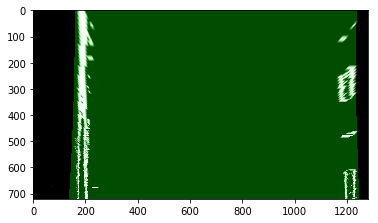

In [19]:
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'test_videos/project_video.mp4'
output_video = 'output_video/output.mp4'

first_pass = True
avg_left_fit = []
avg_right_fit = []

prev_left_fit = []
prev_right_fit = []

clip = VideoFileClip(output)#.subclip(30,50)

white_clip = clip.fl_image(find_lanes) #NOTE: this function expects color images!! ,

%time white_clip.write_videofile(output_video, codec = 'mpeg4', audio=False)